In [29]:
from matplotlib import pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

(0.0, 8.0)

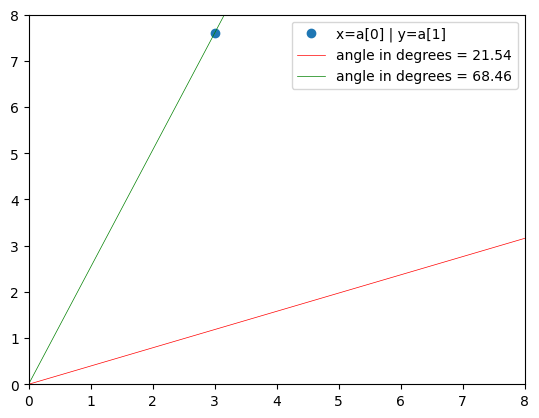

In [30]:
a=np.array([3,7.6]) #correct angle to x axis=68.5 degrees
#usage of ::-1 operator
m_false=np.arctan2(*a)
m_correct=np.arctan2(*a[::-1])
#create basic scatterplot
plt.plot(a[0],a[1], 'o', label="x=a[0] | y=a[1]") #x=3 | y=7.6
# #########################
# #np.arctan2 
# numpy.arctan2(x1, x2,[...]
# Parameters:
              
# x1
# array_like, real-valued
# y-coordinates.

# x2array_like, real-valued
# x-coordinates. 
# ##########################
plt.axline((0, 0), slope=np.tan(m_false), linewidth=0.5, color='r', label = r'angle in degrees = {}'.format(round(np.rad2deg(m_false),2)))
plt.axline((0, 0), slope=np.tan(m_correct), linewidth=0.5, color='g', label = r'angle in degrees = {}'.format(round(np.rad2deg(m_correct),2)))
#plt.plot(a[1][0], m*a[1][0]axline((0, 0), (1, 1), linewidth=4, color='r')+0, '-r', label='y=2x+1')
plt.legend()
#add linear regression line to scatterplot 
#plt.plot(a[1][0], m*a[1][0]+0)
ax = plt.gca()
ax.set_xlim([0, 8])
ax.set_ylim([0, 8])

In [81]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)])
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def render_ep (boat_plot, index=-1, tw_vec=0, sail_angle=0, target=False):
    from matplotlib import pyplot as plt
    #true wind vector
    #plt.figure(figsize=(10, 6), dpi=200)
    #define plots
    fig, ax = plt.subplots()

    #define coordinates and directions
    if tw_vec.all!=0:
        x = 1
        y = 0.02
        u = tw_vec[0]
        v = tw_vec[1]
    #sail angle   
    if tw_vec.all!=0:
        x1 = 5        
        u1 = sail_angle[0]
        v1 = sail_angle[1]
        sail=ax.quiver(x1, y, u1, v1, color='blue')
        ax.plot([], [], color='blue', label="sail")

    #create quiver plot
    wind=ax.quiver(x, y, u, v, color='black')

    ax.plot([], [], color='black', label="wind")

    #starting point
    #target point
    #PENDING: spline connecting each point
    
    boat_plot=np.split(boat_plot,len(boat_plot)/2)
    #boat_plot=np.split(boat_plot,len(boat_plot)/2)
    boat_plot=np.array(boat_plot)
    #boat_plot=boat_plot[0::50]
    # Scatter plot
    #light blue -> darker blue 
    target_plot=env.target_position
    x=boat_plot[:, 0]
    y=boat_plot[:, 1]
    weights = np.arange(1,boat_plot[:, 1].shape[0]+1)
    
    points_size=np.linspace(1,15,len(boat_plot))
    plt.scatter(x, y, c=weights, cmap='coolwarm' ,s=points_size)
    #plt.scatter(figsize=(5, 5))
    if index!=-1:
        plt.title(f"{index}-th episode")
    if target==True:
        plt.scatter(target_plot[0], target_plot[1], marker="x",  c='green',s=100)
    # Display the plot
    from matplotlib.pyplot import figure

    ax.legend()
    
    #plt.xlim(2*min(x),2*max(x))
    #plt.ylim(2*min(y),2*max(y))
    #plt.xlim(11,15)
    #plt.ylim(0,0.5)
    plt.show()




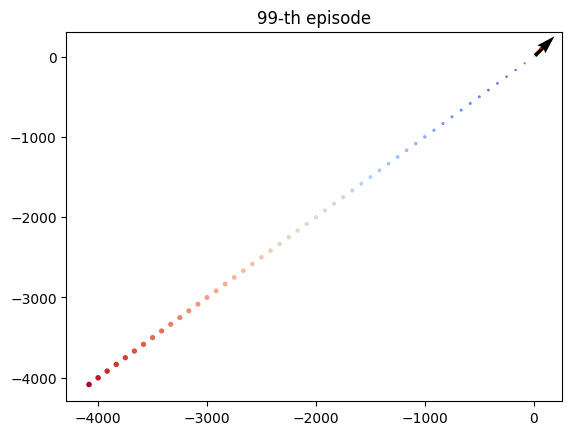

In [233]:
render_ep(boat_plot_all_ep[i],i, vec, True)

In [12]:
np.rad2deg(np.pi/6)

29.999999999999996

In [231]:
np.rad2deg(np.linspace(0, np.pi, 5))

array([  0.,  45.,  90., 135., 180.])

In [220]:
np.

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265])

 # sail angles

In [421]:
np.rad2deg(np.pi/2+np.linspace(0, np.pi/4, 5))

array([ 90.  , 101.25, 112.5 , 123.75, 135.  ])

In [426]:
unit_vector(env.sail_configs[0])

array([1., 0.])

In [96]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.35):
        self.step_num=0
        #self.true_wind_direction = np.random.uniform(0, 2*np.pi)
        #PENDING: starting boat pos + target pos kalytera na orizontai sthn init para sthn reset
        #kai h reset na ta pairnei apo tin init
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([55,100])
        #to heading einai katheto sto sail, ara an to sail einai stis 90 moires to global x axis, to heading einai stis 0 moires, koitaei pros to +apeiro
        self.sail_configs = np.linspace(0, 1.5*np.pi, 5) #angles (in radians) of sail to x global axis

        self.tw_possible_angles=np.linspace(0, np.pi, 5) #angles (in radians) of true wind direction to x global axis
        
        

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.tw_possible_angles
        self.step_num=0        
        self.true_wind_direction = self.tw_possible_angles[1]
        self.boat_position = np.array([0, 0]) #fixed starting point
        self.target_position = np.array([4,0]) #fixed target position
        self.tw_velocity_vector=unit_vector(self.true_wind_direction)
        #self.boat_velocity = self.tw_velocity_vector
        print(f"{self.step_num}: Wind Velocity = {self.tw_velocity_vector}")
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0], 1
        
        

#     def get_state(self):
#         relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])

#         distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
#         return relative_wind_direction, distance_to_target

    def step(self, action):

        sail_config = action
        self.heading=sail_config #heading = h gwnia twn paniwn se sxesh me ton global x aksona
        #print(f"heading -> {self.heading}")
        #sail_force = sail_config * np.sin(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        #sail_force = sail_config * np.sin(self.true_wind_direction - self.heading)
        #print(f"gwnia: -> {np.sin(self.true_wind_direction - self.heading)} -> sail force={sail_force}")
        #print(f"gwnia? {np.arctan2(*self.boat_position[::-1])}")
        #boat_velocity = np.array([np.cos(self.true_wind_direction), np.sin(self.true_wind_direction)]) * sail_force 
        #scale = 1.3 # for debugging only
        self.heading_vector=unit_vector(sail_config) #unit vector heading
        nominator = self.heading_vector @ self.tw_velocity_vector
        denominator= self.heading_vector @ self.heading_vector
        
        self.boat_velocity = self.heading_vector*nominator*denominator# * scale
        self.boat_position_old=self.boat_position
        self.boat_position = self.boat_position + self.boat_velocity#.astype(np.float64)

        
        self.step_num+=1
        
        print(f"{self.step_num}: V={np.round(self.boat_velocity,2)} /-/ P={np.round(self.boat_position,2)}\
        /-/ paragontas={round(nominator*denominator,2)} /-/ Sail Angle to X = {np.rad2deg(np.pi/2+sail_config)} moires\
        /-/ DF: {np.round(np.linalg.norm(self.boat_position_old-self.boat_position),2)}")
        #print(f"{self.step_num}: {self.boat_position_old}")
        
        done = False
        truncated = False
        reward = -1


        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        if distance_to_target < 1:

            done = True
            reward = 100
        
        if self.step_num >= 50 or not np.any(np.round(self.boat_velocity,2)):
            truncated = True



        return self.boat_position, {} ,{}, reward, done, truncated, self.step_num


In [425]:
env=SailBoatEnvironment()
#pos, wind, _ = env.reset()
env.reset()[1]

reset velocity = [1. 0.]


0

In [224]:

action=env.sail_configs[2]
env.step(action)

heading -> 1.5707963267948966
gwnia: -> -0.7071067811865476 -> sail force=-1.1107207345395915


(array([-3.14159265, -3.14159265]), {}, {}, -1, False, False, 5)

In [89]:
env.tw_possible_angles[wind]

0.0

In [84]:
unit_vector(env.tw_possible_angles[wind])

array([ 0.42417901, -0.90557836])

In [ ]:
env.tw_possible_angles[]

In [341]:
env=SailBoatEnvironment()
#current state = true wind direction + angle of boat to target wrt x axis
#prwto einai gia true wind angles
a=len(env.tw_possible_angles)

#deytero ola ta possible actions
b=len(env.sail_configs)
q_table = np.random.uniform(low=-2, high=0, size=(a,b))
#q_table
#wd=0,1,2 # wd=1
#dt=0,1 #dt=0 makria, dt=1 konta
#np.argmax(q_table[1,1])
#
#rudder conf = 0:15th column
#np.argmax(q_table[state,0:15])
#sail conf = 16:31th columns
#np.argmax(q_table[state,16:32])



In [143]:
current_state=env.reset()    
current_state=current_state[1]

In [144]:
np.argmax(q_table[current_state])


3

In [140]:
q_table[current_state]

array([-0.73939776, -1.35718944, -0.46856029, -0.29806435])

In [147]:
sail_conf_index=np.argmax(q_table[current_state])

#print(f"{i} ep: sail index->{sail_conf_index}, rudder index->{rudder_conf_index}")
#H np.argmax epistrefei index, oxi timh, opote pairnoume to index pou mas epistrefei
#kai blepoume apo ta *_configs poia timh antistoixei se ayto to index
sail_conf_index

3

In [150]:
q_table[current_state]

array([-0.73939776, -1.35718944, -0.46856029, -0.29806435])

In [151]:
q_table[current_state,3]

-0.2980643490160091

# Train Q table

0: Wind Velocity = [0.70710678 0.70710678]
1: V=[0.84 0.22] /-/ P=[0.84 0.22]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
2: V=[0.84 0.22] /-/ P=[1.67 0.45]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
3: V=[0.84 0.22] /-/ P=[2.51 0.67]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
4: V=[0.84 0.22] /-/ P=[3.35 0.9 ]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
5: V=[0.84 0.22] /-/ P=[4.18 1.12]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
6: V=[0.84 0.22] /-/ P=[5.02 1.34]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
7: V=[0.84 0.22] /-/ P=[5.86 1.57]        /-/ paragontas=0.87 /-/ Sail Angle to X = 105.0 moires        /-/ DF: 0.87
8: V=[0.79 0.59] /-/ P=[6.65 2.16]        /-/ paragontas=-0.99 /-/ Sail Angle to X = 306.55 moires        /-/ DF: 0.99
9: V=[0.79 0.59] /-

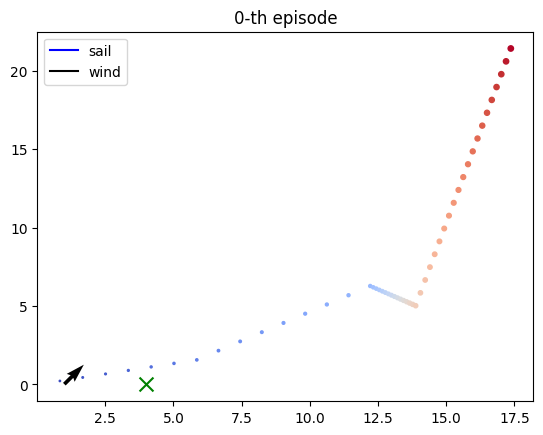

In [97]:
env=SailBoatEnvironment()
EPISODES=1
tw_direction=[]
boat_plot=[]
boat_plot_all_ep=[] #stores all episodes' movement
dones=np.zeros(EPISODES)
for i in range(EPISODES):
    boat_plot=[]
    current_state=env.reset()    
    current_state=current_state[1]
    tw_direction=np.append(tw_direction,current_state)
    done=False
    truncated=False
    step_num=0
    while not done: # or not truncated:

        #sail_conf_index=np.argmax(q_table[current_state])
        
        #print(f"{i} ep: sail index->{sail_conf_index}, rudder index->{rudder_conf_index}")
        #H np.argmax epistrefei index, oxi timh, opote pairnoume to index pou mas epistrefei
        #kai blepoume apo ta *_configs poia timh antistoixei se ayto to index
        
        #action=env.sail_configs[sail_conf_index]
        
        #action=env.sail_configs[0]
        
        if step_num < 7:
            action=np.deg2rad(15)
        elif step_num < 15:
            action=np.deg2rad(216.55)
        elif step_num < 30:
            action=np.deg2rad(143)
        else:
            action=np.deg2rad(78)
        #action=np.deg2rad(15)
        boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
        
        #print(f"step:{step_num}: boat position={boat_pos}")
        
        if done==True:
            print(f"{i}-th ep -> Egina done sto {step_num}-th step.")
            dones[i]=1
            break

        
        boat_plot=np.append(boat_plot,np.array(boat_pos))
        
        if truncated==True:
            #print(f"{i}-th ep -> Egina truncated")
            break

        #Psaxnoume ta Q_max, ena gia to sail setting kai ena gia to rudder setting
        #Sto Q table exoume orisei aythaireta oti oi prwtes 16 columns [0:16] dhladh
        #antistoixoun sto sail setting
        #enw oi ypoloipes 16 columns [16:33] sto rudder config
        
#         Q_max=np.max(q_table[(current_state)])
        
#         q_current=q_table[current_state,sail_conf_index]

#         new_q=(1-env.alpha)*q_current+env.alpha*(reward+env.gamma*Q_max)

#         q_table[current_state,sail_conf_index]=new_q

        

    #print(i)
    boat_plot_all_ep.append(boat_plot)
#     if i%800==0:
#         print(f"{i}-th ep -> steps: {step_num}")
    
#plot last episode
#render_ep(boat_plot, EPISODES)
vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
action=unit_vector(action)
#render_ep(boat_plot_all_ep[i],i, vec, action, True)
render_ep(boat_plot_all_ep[i],i, vec, np.array([0,0]), True)

In [176]:
boat_plot_all_ep[0]

array([-3.84734139e-16,  4.71163432e-32, -3.84734139e-16, ...,
        4.71163432e-32, -3.84734139e-16,  4.71163432e-32])

In [185]:
np.split(boat_plot_all_ep[0],len(boat_plot_all_ep[0])/2)

[array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.39269908, 0.39269908]),
 array([0.3926